# Report Generation Tutorial

PyGSTi is able to construct polished report documents, which provide high-level summaries as well as detailed analyses of results (Gate Set Tomography (GST) and model-testing results in particular).  Reports are intended to be quick and easy way of analyzing `Model`-type estimates, and pyGSTi's report generation functions are specifically designed to interact with the `ModelEstimateResults` object (producted by several high-level algorithm functions - see, for example, the [GST overview tutorial](../algorithms/GST-Overview.ipynb) and [GST functions tutorial](../algorithms/GST-Drivers.ipynb).).  The report generation functions in pyGSTi takes one or more results (often `ModelEstimateResults`-type) objects as input and produces an HTML file as output.  The HTML format allows the reports to include **interactive plots** and **switches** (see the [workspace switchboard tutorial](advanced/WorkspaceSwitchboards.ipynb), making it easy to compare different types of analysis or data sets.  

PyGSTi's reports are stand-alone HTML documents which cannot run Python.  Thus, all the results displayed in a report must be pre-computed (in Python).  If you find yourself wanting to fiddle with things and feel that these reports are too static, please consider using a `Workspace` object (see the [Workspace tutorial](Workspace.ipynb)) within a Jupyter notebook, where you can intermix report tables/plots and Python.  Internally, functions like `construct_standard_report` (see below) are simple factories for `Report` objects, which are in turn little more than a wrapper around a `Workspace` object and a set of instructions for how to generate reports of different output formats.


### Get some `ModelEstimateResults`
We start by performing GST using `run_long_sequence_gst`, as usual, to create a `ModelEstimateResults` object (we could also have just loaded one from file).  See the [GST functions tutorial](../algorithms/GST-Driverfunctions.ipynb) for more details.

In [1]:
import pygsti
from pygsti.modelpacks import smq1Q_XYI

target_model = smq1Q_XYI.target_model()
prep_fiducials = smq1Q_XYI.prep_fiducials()
meas_fiducials = smq1Q_XYI.meas_fiducials()
germs = smq1Q_XYI.germs()
maxLengths = [1,2,4,8,16]
ds = pygsti.io.load_dataset("../tutorial_files/Example_Dataset.txt", cache=True)

#Run GST
target_model.set_all_parameterizations("TP") #TP-constrained
results = pygsti.run_long_sequence_gst(ds, target_model, prep_fiducials, meas_fiducials, germs,
                                      maxLengths, verbosity=3)

Loading from cache file: ../tutorial_files/Example_Dataset.txt.cache
--- Circuit Creation ---
   616 circuits created
   Dataset has 1120 entries: 616 utilized, 0 requested circuits were missing
--- LGST ---
  Singular values of I_tilde (truncating to first 4 of 6) = 
  4.2448383395140565
  1.1797098845149432
  0.9634439008898883
  0.9362764670582103
  0.043526347617574755
  0.016484656607311327
  
  Singular values of target I_tilde (truncating to first 4 of 6) = 
  4.242640687119283
  1.4142135623730956
  1.414213562373095
  1.4142135623730938
  6.033024285550424e-16
  1.158109689322031e-16
  


/Users/sserita/Documents/repos/pyGSTi/pygsti/objects/evaltree.py:192: UserWarning: Created an evaluation tree that is inefficient: tree-size > 3 * #circuits !
This is likely due to the fact that the circuits being simulated do not have a
periodic structure. Consider using a different forward simulator (e.g. MapForwardSimulator).
  _warnings.warn(("Created an evaluation tree that is inefficient: tree-size > %d * #circuits !\n"


--- Iterative GST: Iter 1 of 5  92 circuits ---: 
  --- chi2 GST ---
    --- Outer Iter 0: norm_f = 78.9405, mu=1, |x|=2.97086, |J|=1399.82
    --- Outer Iter 1: norm_f = 54.0573, mu=218.635, |x|=2.97863, |J|=4004
    --- Outer Iter 2: norm_f = 51.8745, mu=72.8784, |x|=2.98084, |J|=4003.02
    --- Outer Iter 3: norm_f = 51.8719, mu=24.2928, |x|=2.98111, |J|=4003.04
    Least squares message = Both actual and predicted relative reductions in the sum of squares are at most 1e-06
  Sum of Chi^2 = 51.8719 (92 data params - 31 model params = expected mean of 61; p-value = 0.791166)
  Completed in 0.1s
  Iteration 1 took 0.1s
  
--- Iterative GST: Iter 2 of 5  168 circuits ---: 
  --- chi2 GST ---
    --- Outer Iter 0: norm_f = 157.079, mu=1, |x|=2.98112, |J|=4118.85
    --- Outer Iter 1: norm_f = 127.64, mu=1805.26, |x|=2.97344, |J|=4115.26
    --- Outer Iter 2: norm_f = 123.007, mu=601.752, |x|=2.9702, |J|=4114.74
    --- Outer Iter 3: norm_f = 122.594, mu=200.584, |x|=2.96944, |J|=4114.66

### Make a report
Now that we have `results`, we use the `construct_standard_report` method within `pygsti.report` to generate a `Report`.  
`pygsti.report.construct_standard_report` is the most commonly used report factory function in pyGSTi, as it is appropriate for smaller models (1- and 2-qubit) which have *operations that are or can be represeted as dense matrices and/or vectors*.  

Once constructed, a `Report` object can be used to write a report as an HTML document, PDF, or notebook.  To open a HTML-format report, you open the `main.html` file directly inside the report's folder.  Setting `auto_open=True` makes the finished report open in your web browser automatically.  

Running idle tomography
Computing switchable properties
Found standard clifford compilation from smq1Q_XYI


/Users/sserita/Documents/repos/pyGSTi/pygsti/objects/evaltree.py:192: UserWarning:

Created an evaluation tree that is inefficient: tree-size > 3 * #circuits !
This is likely due to the fact that the circuits being simulated do not have a
periodic structure. Consider using a different forward simulator (e.g. MapForwardSimulator).

/Users/sserita/Documents/repos/pyGSTi/pygsti/objects/evaltree.py:192: UserWarning:

Created an evaluation tree that is inefficient: tree-size > 10 * #circuits !
This is likely due to the fact that the circuits being simulated do not have a
periodic structure. Consider using a different forward simulator (e.g. MapForwardSimulator).





Generating LaTeX source...


/Users/sserita/Documents/repos/pyGSTi/pygsti/report/mpl_colormaps.py:656: UserWarning:

FixedFormatter should only be used together with FixedLocator

/Users/sserita/Documents/repos/pyGSTi/pygsti/report/mpl_colormaps.py:657: UserWarning:

FixedFormatter should only be used together with FixedLocator



AttributeError: 'tuple' object has no attribute 'strip'

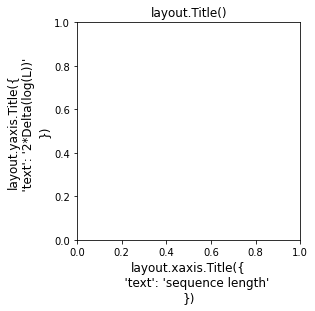

In [2]:
report = pygsti.report.construct_standard_report(results, title="GST Example Report", verbosity=1)
#HTML
report.write_html("../tutorial_files/exampleReport", auto_open=True, verbosity=1)

print("\n")

#PDF
report.write_pdf("../tutorial_files/exampleReport.pdf", auto_open=True, verbosity=1)

There are several remarks about these reports worth noting:
1. The **HTML reports are the primary report type in pyGSTi**, and are much more flexible.  The PDF reports are more limited (they can only display a *single* estimate and gauge optimization), and essentially contain a subset of the information and descriptive text of a HTML report.  So, if you can, use the HTML reports.  The PDF report's strength is its portability: PDFs are easily displayed by many devices, and they embed all that they need neatly into a single file.  **If you need to generate a PDF report** from `Results` objects that have multiple estimates and/or gauge optimizations, consider using the `Results` object's `view` method to single out the estimate and gauge optimization you're after.
2. It's best to use **Firefox** when opening the HTML reports. (If there's a problem with your brower's capabilities it will be shown on the screen when you try to load the report.)
3. You'll need **`pdflatex`** on your system to compile PDF reports.
4. To familiarize yourself with the layout of an HTML report, click on the gray **"Help" link** on the black sidebar.

### Multiple estimates in a single report
Next, let's analyze the same data two different ways: with and without the TP-constraint (i.e. whether the gates *must* be trace-preserving) and furthermore gauge optmimize each case using several different SPAM-weights.  In each case we'll call `run_long_sequence_gst` with `gauge_opt_params=False`, so that no gauge optimization is done, and then perform several gauge optimizations separately and add these to the `Results` object via its `add_gaugeoptimized` function.

In [ ]:
#Case1: TP-constrained GST
tpTarget = target_model.copy()
tpTarget.set_all_parameterizations("TP")
results_tp = pygsti.run_long_sequence_gst(ds, tpTarget, prep_fiducials, meas_fiducials, germs,
                                      maxLengths, gauge_opt_params=False, verbosity=1)

#Gauge optimize
est = results_tp.estimates['GateSetTomography']
mdlFinal = est.models['final iteration estimate']
mdlTarget = est.models['target']
for spamWt in [1e-4,1e-2,1.0]:
    mdl = pygsti.gaugeopt_to_target(mdlFinal,mdlTarget,{'gates':1, 'spam':spamWt})
    est.add_gaugeoptimized({'item_weights': {'gates':1, 'spam':spamWt}}, mdl, "Spam %g" % spamWt)

In [ ]:
#Case2: "Full" GST
fullTarget = target_model.copy()
fullTarget.set_all_parameterizations("full")
results_full = pygsti.run_long_sequence_gst(ds, fullTarget, prep_fiducials, meas_fiducials, germs,
                                           maxLengths, gauge_opt_params=False, verbosity=1)

#Gauge optimize
est = results_full.estimates['GateSetTomography']
mdlFinal = est.models['final iteration estimate']
mdlTarget = est.models['target']
for spamWt in [1e-4,1e-2,1.0]:
    mdl = pygsti.gaugeopt_to_target(mdlFinal,mdlTarget,{'gates':1, 'spam':spamWt})
    est.add_gaugeoptimized({'item_weights': {'gates':1, 'spam':spamWt}}, mdl, "Spam %g" % spamWt)

We'll now call the *same* `construct_standard_report` function but this time instead of passing a single `Results` object as the first argument we'll pass a *dictionary* of them.  This will result in a **HTML report that includes switches** to select which case ("TP" or "Full") as well as which gauge optimization to display output quantities for.  PDF reports cannot support this interactivity, and so **if you try to generate a PDF report you'll get an error**.

In [ ]:
ws = pygsti.report.Workspace()
report = pygsti.report.construct_standard_report(
    {'TP': results_tp, "Full": results_full}, title="Example Multi-Estimate Report", ws=ws, verbosity=2)
report.write_html("../tutorial_files/exampleMultiEstimateReport", auto_open=True, verbosity=2)

In the above call we construct `ws` - a `Workspace` object.  PyGSTi's `Workspace` objects function as both a factory for figures and tables as well as a smart cache for computed values.  A `Workspace` object can optionally be passed as an argument to `construct_standard_report`, where it is used to create all figures in the report.  As an intended side effect, each of these figures is cached, along with some of the intermediate results used to create it.  By passing a preconstructed `Workspace` object to `construct_standard_report`, we allow it to utilize previously cached quantities.

**Another way**: Because both `results_tp` and `results_full` above used the same dataset and operation sequences, we could have combined them as two estimates in a single `ModelEstimateResults` object (see the previous tutorial on pyGSTi's results objects).  This can be done by renaming at least one of the `"default"`-named estimates in `results_tp` or `results_full` (below we rename both) and then adding the estimate within `results_full` to the estimates already contained in `results_tp`: 

In [ ]:
results_tp.rename_estimate('GateSetTomography','TP')
results_full.rename_estimate('GateSetTomography','Full')
results_both = results_tp.copy() #copy just for neatness
results_both.add_estimates(results_full, estimatesToAdd=['Full'])

Creating a report using `results_both` will result in the same report we just generated.  We'll demonstrate this anyway, but in addition we'll supply `construct_standard_report` with the same `Workspace` we previously used to generate a report.  This tells the constructed `Report` to use any cached values contained in a given *input* `Workspace` to expedite report generation.  Since our workspace object has the exact quantities we need cached in it, you'll notice a significant speedup.  Finally, note that even though there's just a single `Results` object, you **still can't generate a PDF report** from it because it contains multiple estimates.

In [ ]:
pygsti.report.construct_standard_report(
    results_both,
    title="Example Multi-Estimate Report (v2)", 
    ws=ws, verbosity=2
).write_html("../tutorial_files/exampleMultiEstimateReport2", auto_open=True, verbosity=2)

### Multiple estimates and `run_stdpractice_gst`
It's no coincidence that a `Results` object containing multiple estimates using the same data is precisely what's returned from `run_stdpractice_gst` (see docstring for information on its arguments, and see the [GST functions tutorial](../algorithms/GST-Drivers.ipynb)).  This allows one to run GST multiple times, creating several different "standard" estimates and gauge optimizations, and plot them all in a single (HTML) report. 

In [ ]:
results_std = pygsti.run_stdpractice_gst(ds, target_model, prep_fiducials, meas_fiducials, germs,
                                        maxLengths, verbosity=4, modes="TP,CPTP,Target",
                                        gauge_opt_suite=('stdgaugeopt','toggleValidSpam'))

# Generate a report with "TP", "CPTP", and "Target" estimates
pygsti.report.construct_standard_report(
    results_std, title="Post StdPractice Report", verbosity=1
).write_html("../tutorial_files/exampleStdReport", auto_open=True, verbosity=1)

### Reports with confidence regions
To display confidence intervals for reported quantities, you must do two things:

1. you must specify the `confidenceLevel` argument to `construct_standard_report`.
2. the estimate(s) being reported must have a valid confidence-region-factory.

Constructing a factory often means computing a Hessian, which can be time consuming, and so this is *not* done automatically.  Here we demonstrate how to construct a valid factory for the "Spam 0.001" gauge-optimization of the "CPTP" estimate by computing and then projecting the Hessian of the likelihood function. 

In [ ]:
#Construct and initialize a "confidence region factory" for the CPTP estimate
crfact = results_std.estimates["CPTP"].add_confidence_region_factory('Spam 0.001', 'final')
crfact.compute_hessian(comm=None) #we could use more processors
crfact.project_hessian('intrinsic error')

pygsti.report.construct_standard_report(
    results_std, title="Post StdPractice Report (w/CIs on CPTP)",
    confidenceLevel=95, verbosity=1
).write_html("../tutorial_files/exampleStdReport2", auto_open=True, verbosity=1)

### Reports with multiple *different* data sets
We've already seen above that `construct_standard_report` can be given a dictionary of `Results` objects instead of a single one.  This allows the creation of reports containing estimates for different `DataSet`s (each `Results` object only holds estimates for a single `DataSet`).  Furthermore, when the data sets have the same operation sequences, they will be compared within a tab of the HTML report.

Below, we generate a new data set with the same sequences as the one loaded at the beginning of this tutorial, proceed to run standard-practice GST on that dataset, and create a report of the results along with those of the original dataset.  Look at the **"Data Comparison" tab** within the gauge-invariant error metrics category.

In [ ]:
#Make another dataset & estimates
depol_gateset = target_model.depolarize(op_noise=0.1)
datagen_gateset = depol_gateset.rotate((0.05,0,0.03))

#Compute the sequences needed to perform Long Sequence GST on 
# this Model with sequences up to lenth 512
circuit_list = pygsti.construction.create_lsgst_circuits(
    smq1Q_XYI.target_model(), smq1Q_XYI.prep_fiducials(), smq1Q_XYI.meas_fiducials(),
    smq1Q_XYI.germs(), [1,2,4,8,16,32,64,128,256,512])
ds2 = pygsti.construction.simulate_data(datagen_gateset, circuit_list, n_samples=1000,
                                             sample_error='binomial', seed=2018)
results_std2 = pygsti.run_stdpractice_gst(ds2, target_model, prep_fiducials, meas_fiducials, germs,
                                     maxLengths, verbosity=3, modes="TP,CPTP,Target",
                                     gauge_opt_suite=('stdgaugeopt','toggleValidSpam'))

pygsti.report.construct_standard_report(
    {'DS1': results_std, 'DS2': results_std2},
    title="Example Multi-Dataset Report", verbosity=1
).write_html("../tutorial_files/exampleMultiDataSetReport", auto_open=True, verbosity=1)

### Other cool `Report` tricks
Finally, let us highlight a few of the additional arguments one can supply to the respective `Report` output methods that allows further control over what gets included in the generated report.

- Setting the `link_to` argument to a tuple of `'pkl'`, `'tex'`, and/or `'pdf'` will create hyperlinks within the plots or below the tables of the HTML linking to Python pickle, LaTeX source, and PDF versions of the content, respectively.  The Python pickle files for tables contain pickled pandas `DataFrame` objects, wheras those of plots contain ordinary Python dictionaries of the data that is plotted.  Applies to HTML reports only.

- Setting the `brevity` argument to an integer higher than $0$ (the default) will reduce the amount of information included in the report (for details on what is included for each value, see the doc string).  Using `brevity > 0` will reduce the time required to create, and later load, the report, as well as the output file/folder size.  This applies to both HTML and PDF reports.

Below, we demonstrate both of these options in very brief (`brevity=4`) report with links to pickle and PDF files.  Note that to generate the PDF files you must have `pdflatex` installed.

In [ ]:
pygsti.report.construct_standard_report(
    results_std, title="Example Brief Report", verbosity=1
).write_html("../tutorial_files/exampleBriefReport", auto_open=True, verbosity=1,
             brevity=4, link_to=('pkl', 'pdf'))

## Advanced Reports: `Report.write_notebook`
In addition to the standard HTML-page reports demonstrated above, pyGSTi is able to generate a Jupyter notebook containing the Python commands to create the figures and tables within a general report.  This is facilitated
by `Workspace` objects, which are factories for figures and tables (see previous tutorials).  By calling `Report.write_notebook`, all of the relevant `Workspace` initialization and calls are dumped to a new notebook file, which can be run (either fully or partially) by the user at their convenience.  Creating such "report notebooks" has the advantage that the user may insert Python code amidst the figure and table generation calls to inspect or modify what is display in a highly customizable fashion.  The chief disadvantages of report notebooks is that they require the user to 1) have a Jupyter server up and running and 2) to run the notebook before any figures are displayed.

The line below demonstrates how to create a report notebook using `write_notebook`.  Note that the argument list is very similar to the other `Report` output methods.

In [ ]:
pygsti.report.construct_standard_report(
    results, title="GST Example Report Notebook", confidenceLevel=None, verbosity=3
).write_notebook("../tutorial_files/exampleReport.ipynb", auto_open=True, connected=False, verbosity=3)

## Multi-qubit reports
The dimension of the density matrix space with with more than 2 qubits starts to become quite large, and Models for 3+ qubits rarely allow every element of the operation process matrices to vary independently.  As such, many of the figures generated by `construct_standard_report` are both too unwieldy (displaying a $64 \times 64$ grid of colored boxes for each operation) and not very helpful (you don't often care about what each element of an operation matrix is).  For this purpose, we are developing a report that doesn't just dump out and analyze operation matrices as a whole, but looks at a `Model`'s structure to determine how best to report quantities.  This "n-qubit report" is invoked using `pygsti.report.construct_nqnoise_report`, and has similar arguments to `construct_standard_report`.  It is, however <b style="color:red">still under development</b>, and while you're welcome to try it out, it may crash or not work in other weird ways.